In [13]:
import numpy as np
import numba
from matplotlib import pyplot as plt
from numba import cuda
import math
from time import time
from PIL import Image


In [14]:
def salt_and_pepper_add(image, prob):
  rnd = np.random.rand(image.shape[0], image.shape[1])
  noisy = image.copy()
  noisy[rnd < prob] = 0
  noisy[rnd > 1 - prob] = 255
  return noisy


In [15]:
def median_filter(a):
  b = a.copy()
  start = time()
  for i in range(2, len(a)-1):
    for j in range(2, len(a[i])-1):
      t=[0, 0, 0, 0, 0, 0, 0, 0, 0]
      t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
      for k in range(8):
        for l in range(8-k):
          if t[l]>t[l+1]:
            t[l], t[l+1] = t[l+1], t[l]
      b[i][j]=t[(int)(len(t)/2)]
  return b, time()-start


In [16]:
@cuda.jit
def gpu_median_filter(a, b):
  i, j = cuda.grid(2)
  t=cuda.local.array(shape=9, dtype=numba.int64)
  t[0], t[1], t[2], t[3], t[4], t[5], t[6], t[7], t[8] = a[i-1][j-1], a[i-1][j], a[i-1][j+1], a[i][j-1], a[i][j], a[i][j+1], a[i+1][j-1], a[i+1][j], a[i+1][j+1]
  for k in range(8):
    for l in range(8-k):
      if t[l]>t[l+1]:
        t[l], t[l+1] = t[l+1], t[l]
  b[i][j]=t[(int)(len(t)/2)]
  

In [17]:
def prepare_and_exec_gpu(a):
  b = a.copy()
  tread_number_block = 32

  a_global = cuda.to_device(a)
  b_global = cuda.to_device(b)
    
  threadsperblock = (tread_number_block, tread_number_block)
  blockspergrid_x = int(math.ceil(a.shape[0] / threadsperblock[1]))
  blockspergrid_y = int(math.ceil(b.shape[1] / threadsperblock[0]))
  blockspergrid = (blockspergrid_x, blockspergrid_y)

  start = time()
  gpu_median_filter[blockspergrid, threadsperblock](a_global, b_global)
  return b_global.copy_to_host(), time()-start 


In [20]:
def experiment(img_name, need_draw):
  im=(Image.open(img_name)).convert('L')
  if need_draw==True:
    display(im)
  img = np.array(im)

  img = salt_and_pepper_add(img, 0.09)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img)))

  img2, ctime = median_filter(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))

  img2, gtime = prepare_and_exec_gpu(img)
  if need_draw==True:
    display(Image.fromarray(np.uint8(img2)))
  
  n=len(img)*len(img[0])
  print('Количество элементов =', n)
  print('Время на CPU =', ctime)
  print('Время на GPU =', gtime)
  print('Ускорение =', ctime/gtime)
  print()
  return ctime/gtime, n


Количество элементов = 153600
Время на CPU = 1.5593550205230713
Время на GPU = 0.0006608963012695312
Ускорение = 2359.4549062049064

Количество элементов = 480000
Время на CPU = 5.037527322769165
Время на GPU = 0.0008785724639892578
Ускорение = 5733.764179104478

Количество элементов = 983040
Время на CPU = 10.301622867584229
Время на GPU = 0.0018415451049804688
Ускорение = 5594.0106162610045

Количество элементов = 24000000
Время на CPU = 249.74744367599487
Время на GPU = 0.01694631576538086
Ускорение = 14737.565800951068



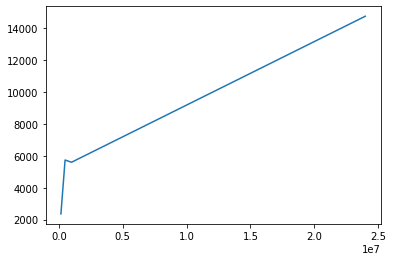

In [22]:
a1, n1 = experiment('img1.jpg', False)
a2, n2 = experiment('img2.jpg', False)
a3, n3 = experiment('img3.jpg', False)
a4, n4 = experiment('img4.jpg', False)

plt.plot([n1, n2, n3, n4], [a1, a2, a3, a4])
plt.show()